In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

In [2]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, activation='relu'):
        super().__init__()
        layers = []

        if activation == 'relu':
            activation_function = nn.ReLU
        elif activation == 'tanh':
            activation_function = nn.Tanh
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_function())
        
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_function())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))  # output size is 1
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [3]:
def train_to_convergence(model,
                         x_train,
                         y_train,
                         optimizer,
                         criterion,
                         loss_threshold=0.01,
                         max_epochs=1000):
    
    #pbar = tqdm(range(max_epochs), desc="Training", unit="epoch")
    #for epoch in pbar:
    for epoch in range(max_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        if loss.item() < loss_threshold:
            break

        loss.backward()
        optimizer.step()
        
        # Update progress bar description
        #bar.set_postfix(loss=loss.item())


In [119]:
for i in range(100):
    print(random.randint(0, 10))

7
9
7
7
10
8
1
7
2
1
3
7
1
8
5
4
1
0
0
8
3
7
8
2
7
7
1
0
3
3
3
7
8
0
3
2
0
4
10
1
3
4
7
3
9
1
1
10
4
1
1
4
3
3
3
9
0
9
2
8
0
6
7
1
9
4
10
4
10
0
1
1
10
4
9
5
10
5
2
3
0
2
2
8
9
9
8
9
0
4
5
9
2
7
2
2
2
0
0
5


In [21]:
class CircleDataset:

    def __init__(self, dim=2, n_classes=10, p_new=0.5):

        self.dim = dim
        self.n_classes = n_classes
        self.p_new = p_new
        
        self.x_list = []
        self.y_class_list = []
        self.y_new_list = []
        self.y_know_list = []

        self.curr_idx = None

    def generate_sample(self):

        if len(self.x_list) == 0 or random.random() < self.p_new:

            y_class = random.randint(0, self.n_classes - 1)
            magnitude = random.random() + 2 * y_class

            vector = torch.randn(self.dim)
            x = magnitude * (vector / vector.norm())

            y_new = 1

            self.x_list.append(x)
            self.y_class_list.append(y_class)
            self.y_new_list.append(y_new)

            self.curr_idx = len(self.x_list) - 1
            self.y_know_list.append(None)
        
        else:

            idx = np.random.randint(low=0, high=len(self.x_list))
            x = self.x_list[idx]
            y_class = self.y_class_list[idx]
            y_new = 0
            self.y_new_list[idx] = y_new
            self.curr_idx = idx

        y_class_onehot = [0] * self.n_classes
        y_class_onehot[y_class] = 1

        return x.unsqueeze(0), torch.tensor([y_new] + y_class_onehot)

    def update_know(self, know):

        self.y_know_list[self.curr_idx] = know
    
    def get_train(self):

        x_tensor = torch.stack(self.x_list, dim=0)
        y_class_indices = torch.tensor(self.y_class_list, dtype=torch.long)
        y_class_tensor = F.one_hot(y_class_indices, num_classes=self.n_classes).float()
        y_new_tensor = torch.tensor(self.y_new_list, dtype=torch.float32).unsqueeze(1)
        y_know_tensor = torch.tensor(self.y_know_list, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.cat((y_new_tensor, y_know_tensor, y_class_tensor), dim=1)

        return x_tensor, y_tensor

In [142]:
#
# Training Loop
#

# Hyperparameters
n_iterations = 2000
input_dim = 100
n_classes = 10
output_dim = n_classes + 2
hidden_dim = 256
n_layers = 2
loss_threshold = 0.02  # stop training when loss falls below this
max_epochs = 1000
learning_rate = 1e-3
weight_decay = 0
activation = 'relu'
criterion_name = 'mae'
if criterion_name == 'mse':
    criterion = nn.MSELoss()
elif criterion_name == 'mae':
    criterion = nn.L1Loss()
elif criterion_name == 'log_loss':
    criterion = nn.BCEWithLogitsLoss()

# Initialize model and optimizer (should it/they be reoptimized every time?)
model = FFNN(input_dim, hidden_dim, output_dim, n_layers, activation)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
dataset = CircleDataset(dim=input_dim, n_classes=n_classes)

# Initialize record-keeping
class_true = []
class_pred = []
new_true = []
new_pred = []
know_true = []
know_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Encounter new sample
    x, y = dataset.generate_sample()
    class_true.append(y[1:].argmax().item())
    new_true.append(y[0].item())

    # Collect prediction
    model.eval()
    with torch.no_grad():
        pred = model(x)
        class_pred.append(pred[0][2:].tolist())
        class_pred_idx = pred[0].argmax().item()
        new_pred.append(pred[0][0].item())
        know_pred.append(pred[0][1].item())
        know = (class_pred_idx == class_true[-1])
        know_true.append(know)
        dataset.update_know(know)

    # Update model
    x_train, y_train = dataset.get_train()
    train_to_convergence(model, x_train, y_train, 
                         optimizer, criterion,
                         loss_threshold=loss_threshold)
    

100%|█████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 323.26it/s]


In [143]:
# Train meta-model with same parameters

meta_input_dim = n_classes + 2
meta_loss_threshold = 0.02

# Initialize model and optimizer
meta_model = FFNN(meta_input_dim, hidden_dim, output_dim, n_layers, activation)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset

class_pred_tensor = torch.tensor(class_pred, dtype=torch.float32)
new_pred_tensor = torch.tensor(new_pred, dtype=torch.float32).unsqueeze(1)
know_pred_tensor = torch.tensor(know_pred, dtype=torch.float32).unsqueeze(1)
meta_x_train = torch.cat((new_pred_tensor, know_pred_tensor, class_pred_tensor), dim=1)

#meta_x_train = torch.cat((base_model_output_train, x_train), dim=1)

class_true_idx = torch.tensor(class_true, dtype=torch.long)
class_true_tensor = F.one_hot(class_true_idx, num_classes=n_classes).float()
new_true_tensor = torch.tensor(new_true, dtype=torch.float32).unsqueeze(1)
know_true_tensor = torch.tensor(know_true, dtype=torch.float32).unsqueeze(1)
meta_y_train = torch.cat((new_true_tensor, know_true_tensor, class_true_tensor), dim=1)

# Initialize record-keeping
meta_class_pred = []
meta_new_pred = []
meta_know_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Collect prediction
    meta_model.eval()
    with torch.no_grad():
        meta_pred = meta_model(meta_x_train[iteration])
        meta_class_pred.append(meta_pred[2:].tolist())
        meta_new_pred.append(meta_pred[0].item())
        meta_know_pred.append(meta_pred[1].item())
        
    # Get current data set
    x_train = meta_x_train[:iteration + 1]
    y_train = meta_y_train[:iteration + 1]

    # Update meta-model
    train_to_convergence(meta_model, x_train, y_train, meta_optimizer, criterion, loss_threshold=meta_loss_threshold)    

100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.70it/s]


In [47]:
# Compute accuracy of base model and meta-model
def accuracy(true, preds, threshold=0.5):
    return (true == (np.array(preds) > threshold)).mean()

In [45]:
# Compute accuracy of base model and meta-model
def onehot_accuracy(true, preds, mode='near'):
    if mode == 'near':
        return (true == np.abs(1 - np.array(preds)).argmin(axis=1)).mean()
    else:
        return (true == np.array(preds).argmax(axis=1)).mean()

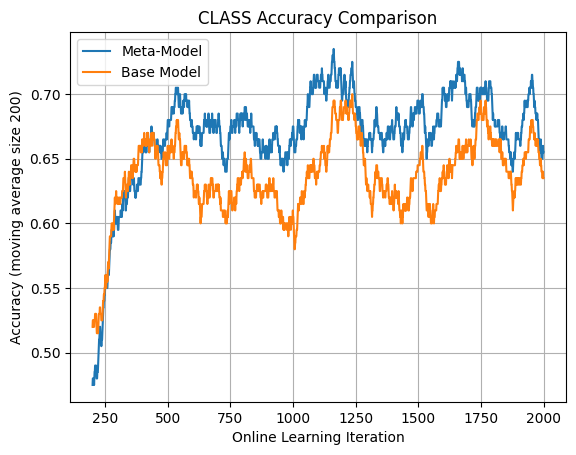

In [144]:
# Plot accuracies over time
window_size = 200
base_accs = []
meta_accs = []
for i in range(window_size, len(class_true)):
    base_accs.append(onehot_accuracy(class_true[i-window_size:i], class_pred[i-window_size:i]))
    meta_accs.append(onehot_accuracy(class_true[i-window_size:i], meta_class_pred[i-window_size:i]))
    
plt.plot(np.arange(window_size, len(class_true)), meta_accs, label='Meta-Model')
plt.plot(np.arange(window_size, len(class_true)), base_accs, label='Base Model')

plt.legend()
plt.ylabel(f"Accuracy (moving average size {window_size})")
plt.xlabel("Online Learning Iteration")
plt.title(f"CLASS Accuracy Comparison")
plt.grid()
plt.show()

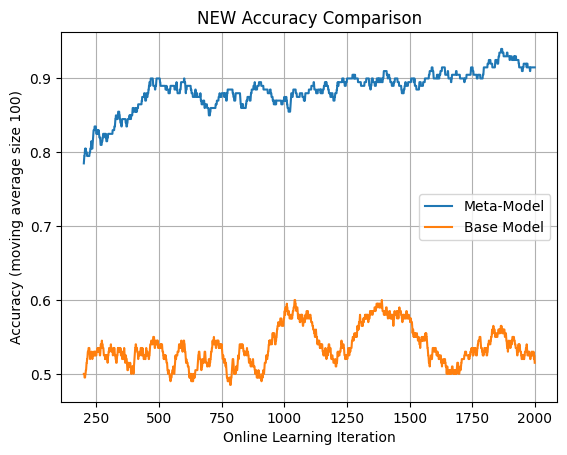

In [145]:
window_size = 200
base_accs = []
meta_accs = []
for i in range(window_size, len(class_true)):
    base_accs.append(accuracy(new_true[i-window_size:i], new_pred[i-window_size:i]))
    meta_accs.append(accuracy(new_true[i-window_size:i], meta_new_pred[i-window_size:i]))
    
plt.plot(np.arange(window_size, len(new_true)), meta_accs, label='Meta-Model')
plt.plot(np.arange(window_size, len(new_true)), base_accs, label='Base Model')
plt.legend()
plt.ylabel("Accuracy (moving average size 100)")
plt.xlabel("Online Learning Iteration")
plt.title(f"NEW Accuracy Comparison")
plt.grid()
plt.show()

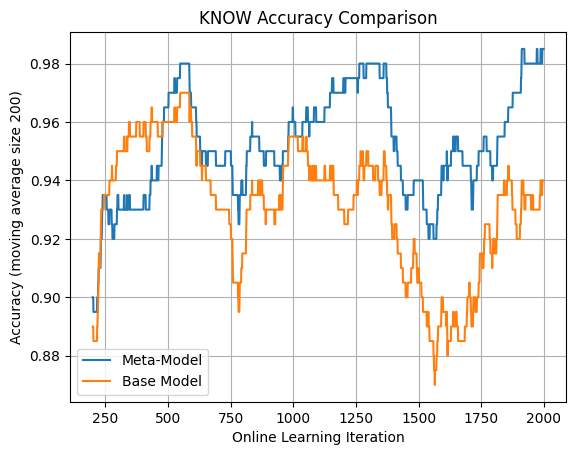

In [146]:
window_size = 200
base_accs = []
meta_accs = []
for i in range(window_size, len(know_true)):
    base_accs.append(accuracy(know_true[i-window_size:i], know_pred[i-window_size:i]))
    meta_accs.append(accuracy(know_true[i-window_size:i], meta_know_pred[i-window_size:i]))
    
plt.plot(np.arange(window_size, len(know_true)), meta_accs, label='Meta-Model')
plt.plot(np.arange(window_size, len(know_true)), base_accs, label='Base Model')
plt.legend()
plt.ylabel(f"Accuracy (moving average size {window_size})")
plt.xlabel("Online Learning Iteration")
plt.title(f"KNOW Accuracy Comparison")
plt.grid()
plt.show()

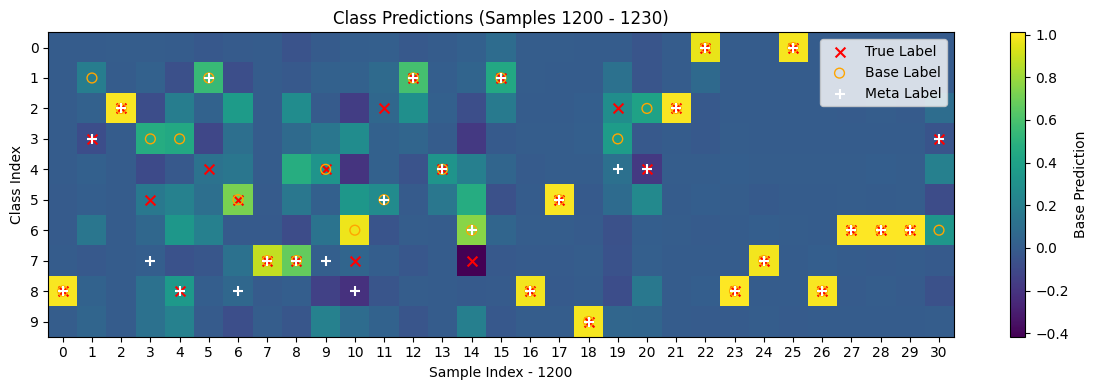

In [151]:
start_sample = 1200
n_samples_to_plot = 31
plt.figure(figsize=(12, 4))
plt.imshow(np.array(class_pred)[start_sample:start_sample+n_samples_to_plot].T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Base Prediction')

x_coords = np.arange(n_samples_to_plot)
y_coords = class_true[start_sample:start_sample+n_samples_to_plot]
plt.scatter(x_coords, y_coords, marker='x', color='red', s=50, label='True Label')

x_coords = np.arange(n_samples_to_plot)
y_coords = np.array(class_pred)[start_sample:start_sample+n_samples_to_plot].argmax(axis=1)
plt.scatter(x_coords, y_coords, marker='o', color='orange', facecolors='none', s=50, label='Base Label')

x_coords = np.arange(n_samples_to_plot)
y_coords = np.array(meta_class_pred)[start_sample:start_sample+n_samples_to_plot].argmax(axis=1)
plt.scatter(x_coords, y_coords, marker='+', color='white', s=50, label='Meta Label')

plt.xlabel(f'Sample Index - {start_sample}')
plt.ylabel('Class Index')
plt.title(f'Class Predictions (Samples {start_sample} - {start_sample + n_samples_to_plot - 1})')
plt.xticks(np.arange(n_samples_to_plot))
plt.yticks(np.arange(10))
plt.legend()
plt.tight_layout()
plt.show()

In [108]:
# Compute accuracy of base model and meta-model
def onehot_accuracy_by_class(true, preds):
    pred_labels = np.abs(1 - np.array(preds)).argmin(axis=1)

    n_classes = np.max(true) + 1
    totals = [0.] * n_classes
    corrects = [0.] * n_classes
    for t, p in zip(true, pred_labels):
        totals[t] += 1
        if t == p:
            corrects[t] += 1
    return [correct / total for correct, total in zip(corrects, totals)]

In [152]:
base_accs_by_class = onehot_accuracy_by_class(class_true, class_pred)
meta_accs_by_class = onehot_accuracy_by_class(class_true, meta_class_pred)

Text(0, 0.5, 'Accuracy')

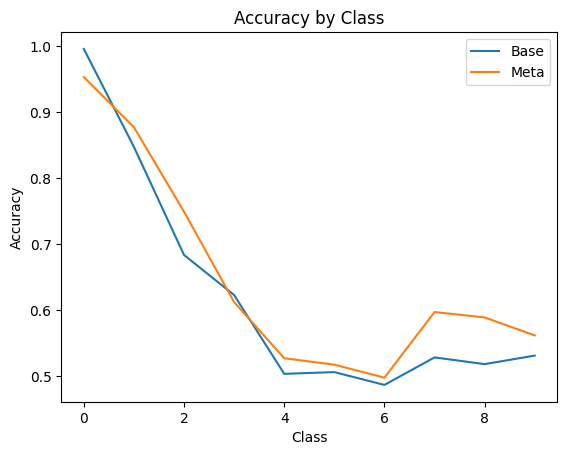

In [153]:
plt.plot(base_accs_by_class, label='Base')
plt.plot(meta_accs_by_class, label='Meta')
plt.title("Accuracy by Class")
plt.legend()
plt.xlabel("Class")
plt.ylabel("Accuracy")

In [114]:
np.max(class_true)

np.int64(8)

In [115]:
len(class_true)

2000